In [35]:
%load_ext autoreload
%autoreload 2

In [37]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from torchvision.ops.boxes import batched_nms, box_area
import cv2
import numpy as np
import logging
import glob
import os

from src.model.utils import Detections
from cnos_clustering_utils import (move_to_device, tighten_bboxes, extract_object_by_mask, _remove_very_small_detections, 
                                    plot_images, extract_sam_crops_features, hierarchical_clustering, analyze_tsne_with_svm
                                    , analyze_tsne_with_kmeans, analyze_tsne_with_svm_3d)
from src.model.custom_cnos import cnos_templates_feature_extraction
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
from sklearn.manifold import TSNE

# Create a logger
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] [%(levelname)s] %(name)s: %(message)s')
log = logging.getLogger(__name__)

In [69]:
dataset = "icbin"
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000014.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
obj_id = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )
move_to_device(custom_sam_model)

rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))

# Remove noise and filter too small and too big crops
noise_remove_sam_detections = tighten_bboxes(sam_detections)
keep_ids = _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"]) # torch.arange(len(noise_remove_sam_detections["masks"])) # 
selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids)) if keep_ids[i]]
# noise_remove_sam_detections = sam_detections
# keep_ids = torch.arange(0, len(noise_remove_sam_detections["masks"]))#  _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"]) # torch.arange(len(noise_remove_sam_detections["masks"])) # 
# selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids))]
# selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids))]
selected_sam_detections = {
    "masks" : torch.stack(selected_masks),
    "boxes" : torch.stack(selected_bboxes)
}
log.info(len(selected_sam_detections["masks"]))
log.info(len(sam_detections["masks"]))

masked_images = []
for mask in selected_sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)
    
# # Plot sam crops
# rows = ceil(len(masked_images) / 6)
# cols = 6
# plot_images(masked_images, rows, cols) 

# Load synthetic train_pbr templates 
out_folder = f"foundpose_analysis/{dataset}/templates"
obj_id_2 = 2
syn_data_type = "train_pbr" # test
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

# Load Dinov2
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)

# Extract features of templates
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )

# Extract feature for all crops
crop_features = extract_sam_crops_features(masked_images, dinov2_vitl14, device)



[2024-09-09 22:14:03,451] [INFO] root: Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything
[2024-09-09 22:14:06,986] [INFO] root: Init CustomSamAutomaticMaskGenerator done!
[2024-09-09 22:14:09,192] [INFO] __main__: 67
[2024-09-09 22:14:09,193] [INFO] __main__: 111
Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
[2024-09-09 22:14:09,788] [INFO] dinov2: using MLP layer as FFN
/home/cuong.van-dam/CuongVanDam/do_an_tot_nghiep/cnos/src/model/constrastive_learning.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_image = F.interpolate(torch.tensor(image).unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W


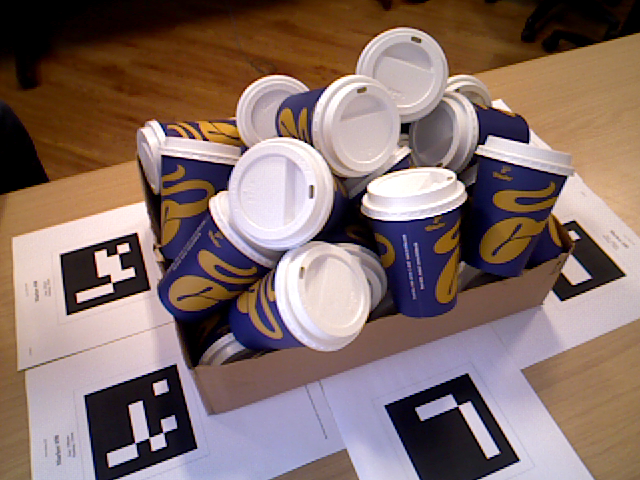

In [71]:
rgb

In [72]:
input_features = torch.cat((syn_ref_features[:162], crop_features), dim=0) # (num_samples, 1024)

In [73]:
log.info(input_features.shape)

# Create and fit the t-SNE model
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(np.array(input_features.cpu()))    


log.info("Done")

[2024-09-09 22:14:16,477] [INFO] __main__: torch.Size([229, 1024])
[2024-09-09 22:14:17,515] [INFO] __main__: Done


Indices of other points classified in the same class as the first class:
[1, 2, 3, 4, 7, 10, 11, 13, 17, 18, 22, 24, 38, 41, 50]
Points in class 0: [1, 2, 3, 4, 7, 10, 11, 13, 17, 18, 22, 24, 38, 41, 50]


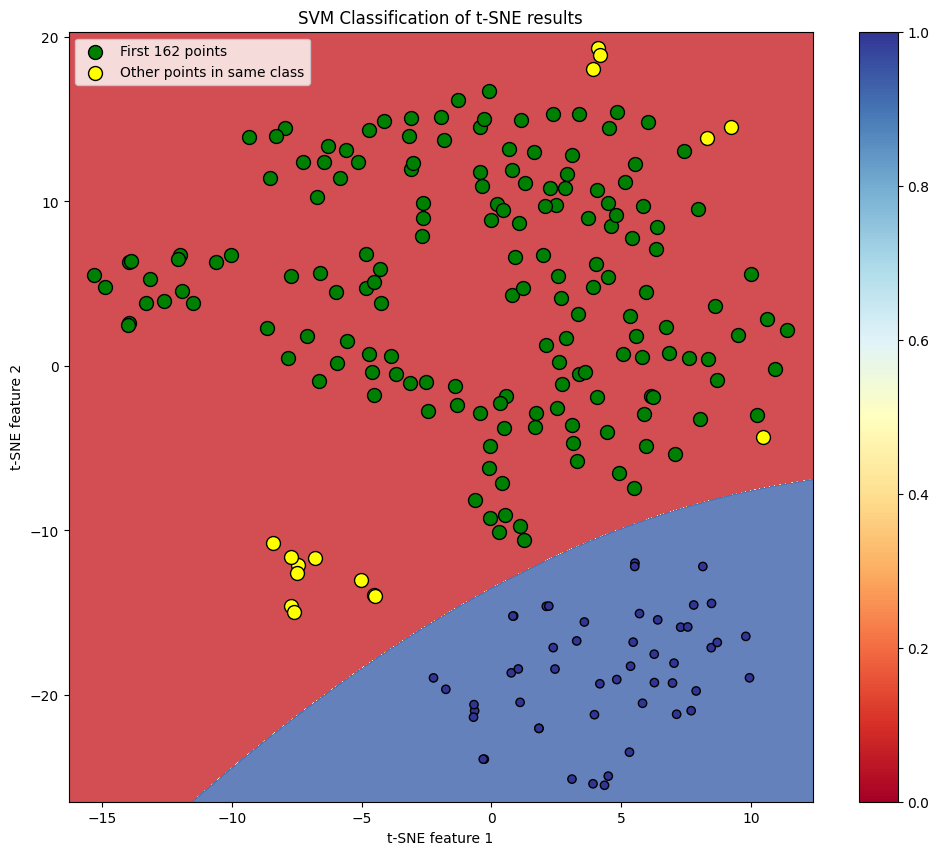

Model accuracy: 0.91


In [75]:
other_same_class, accuracy = analyze_tsne_with_svm(tsne_results=tsne_results, n_samples_first_class=162, total_samples=input_features.shape[0])